In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor

In [3]:
# Loading files with inflation data

In [4]:
ppi = pd.read_csv('cleaned/ppi.csv')

In [5]:
ppi

,time,country,sector,value_var,value_100
0,2015M01,EU,general,-0.7,99.7
1,2015M01,EU,intermediate goods,-0.3,100.0
2,2015M01,EU,energy,-4.3,99.5
3,2015M01,EU,capital goods,0.7,99.6
4,2015M01,EU,durable consumer goods,0.3,99.6
...,...,...,...,...,...
14107,2021M12,Sweden,intermediate goods,-1.2,139.1
14108,2021M12,Sweden,energy,19.3,186.4
14109,2021M12,Sweden,capital goods,0.8,114.0
14110,2021M12,Sweden,durable consumer goods,0.5,121.6


In [53]:
ppi[((ppi['country']=='EU') & (ppi['sector']=='general'))]

,time,country,sector,value_var,value_100
0,2015M01,EU,general,-0.7,99.7
168,2015M02,EU,general,0.6,100.3
336,2015M03,EU,general,0.4,100.7
504,2015M04,EU,general,0.1,100.8
672,2015M05,EU,general,0.1,100.9
...,...,...,...,...,...
13272,2021M08,EU,general,1.0,112.8
13440,2021M09,EU,general,2.0,115.0
13608,2021M10,EU,general,3.7,119.2
13776,2021M11,EU,general,1.6,121.1


In [6]:
hicp = pd.read_csv('cleaned/hicp.csv')

In [7]:
hicp

,time,country,indicator,value_var,value_100
0,2015M01,EU,HICP,-1.3,98.46
1,2015M01,Belgium,HICP,-2.1,97.20
2,2015M01,Bulgaria,HICP,-0.7,99.80
3,2015M01,Czechia,HICP,0.0,99.50
4,2015M01,Denmark,HICP,-0.6,98.90
...,...,...,...,...,...
2347,2021M12,Romania,HICP,0.5,118.76
2348,2021M12,Slovenia,HICP,0.1,109.83
2349,2021M12,Slovakia,HICP,0.2,114.15
2350,2021M12,Finland,HICP,-0.1,107.60


In [8]:
# Loading file with indicators

In [9]:
indicators = pd.read_csv('cleaned/indicators_100.csv')

In [10]:
indicators

,time,country,crude_oil_100,natural_gas_100,coal_100,elec_100,steel_100,copper_100,aluminum_100
0,2015M01,EU,100.00,100.00,100.00,100.00,100.0,100.00,100.00
1,2015M01,Belgium,100.00,100.00,100.00,99.55,100.0,100.00,100.00
2,2015M01,Bulgaria,100.00,100.00,100.00,99.04,100.0,100.00,100.00
3,2015M01,Czechia,100.00,100.00,100.00,98.59,100.0,100.00,100.00
4,2015M01,Denmark,100.00,100.00,100.00,98.15,100.0,100.00,100.00
...,...,...,...,...,...,...,...,...,...
2347,2021M12,Romania,124.67,161.98,271.53,133.30,207.8,151.37,121.29
2348,2021M12,Slovenia,124.67,161.98,271.53,135.95,207.8,151.37,121.29
2349,2021M12,Slovakia,124.67,161.98,271.53,138.49,207.8,151.37,121.29
2350,2021M12,Finland,124.67,161.98,271.53,141.15,207.8,151.37,121.29


In [11]:
ppi['sector'].unique()

array(['general', 'intermediate goods', 'energy', 'capital goods',
       'durable consumer goods', 'non-durable consumer goods'],
      dtype=object)

In [12]:
# DataFrame to store predictions from tests with different models
data=pd.DataFrame(columns=['time', 'target'])
times=pd.date_range("2015-03-01", periods=82, freq="MS")
data['time']=times

In [136]:
sectors=['general']
countries=['EU']
# sectors=ppi['sector'].unique()
# countries=ppi['country'].unique()

In [137]:
# New dataframes to store the scores of simulation, varying type of data (variation, index) and shift between indicators and inflation target
data_train=pd.DataFrame(columns=['country', 'general', 'intermediate goods', 'energy', 'capital goods',
       'durable consumer goods', 'non-durable consumer goods'])
data_test=pd.DataFrame(columns=['country', 'general', 'intermediate goods', 'energy', 'capital goods',
       'durable consumer goods', 'non-durable consumer goods'])

In [138]:
# Linear regression N=2 months
index=0
for country in countries:
    data_train.loc[index,'country']=country
    data_test.loc[index,'country']=country
    for sector in sectors:
        X = indicators[indicators['country']==country]
        X=X.drop(['time', 'country'], axis=1)
        X=X.reset_index(drop=True)
        X=X.drop(X.index[[81, 82]])  # removing last months to fit with target data
        X=X.reset_index(drop=True)
        target = ppi[((ppi['country']==country) & (ppi['sector']==sector))]
        y=target['value_100']
        y=y.reset_index(drop=True)
        # removing first rows (each removed row introduces one month delay between target and X)
#         data['target']=y
        y=y.drop(y.index[[0, 1]]) 
        y=y.reset_index(drop=True)
        data['target']=y
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        scaler = MinMaxScaler().fit(X_train)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)

        lm = LinearRegression()
        lm.fit(X_train_norm,y_train)

        predictions_train = lm.predict(X_train_norm)
        r_train=r2_score(y_train, predictions_train)
        predictions_test = lm.predict(X_test_norm)
        r_test=r2_score(y_test, predictions_test)
        data_train.loc[index, sector]=r_train
        data_test.loc[index, sector]=r_test
        
  #      X=X.iloc[:-2]
        pred=lm.predict(scaler.transform(X))
        data['pred_LR-2M']=pred
        r_test=r2_score(y, pred)
    index+=1

In [139]:
r_test

0.865211002022471

In [1]:
# round(mean_squared_error(y_test, predictions_test),2)

In [126]:
data_test

,country,general,intermediate goods,energy,capital goods,durable consumer goods,non-durable consumer goods
0,EU,0.873756,0.924322,0.807313,0.763308,0.834471,0.822941
1,Belgium,0.907759,0.951001,0.833882,0.884722,0.643322,0.802958
2,Bulgaria,0.81863,0.884014,0.688469,0.822882,0.822777,0.865744
3,Czechia,0.696383,0.84062,0.680339,0.332778,0.706691,0.532016
4,Denmark,0.836229,0.800976,0.797639,0.754288,0.855058,-0.626278
5,Germany,0.902223,0.934026,0.832319,0.85036,0.889574,0.886951
6,Estonia,0.920409,0.880004,0.753917,0.440662,0.947018,0.853831
7,Ireland,0.846589,0.939392,0.841154,0.823543,0.882511,0.84388
8,Greece,0.788372,0.913176,0.735804,0.874543,0.913504,0.614807
9,Spain,0.892193,0.948995,0.827877,0.892096,0.851537,0.909388


In [127]:
data_test.to_csv('tests/ppi-100-LR-2M-test.csv')

In [16]:
# using actual data (March 2022) to predict PPI in May 2022 (N=2)
X1 = {'crude_oil_100':260, 'natural_gas_100':161, 'coal_100':680, 'elec_100':166, 'steel_100':58,
        'copper_100':165, 'aluminum_100':158}
X2=pd.DataFrame(columns=X_train.columns)
        
X2=X2.append(X1, ignore_index=True)
            
X1_norm = scaler.transform(X2)
pred=lm.predict(X1_norm)
pred[0]

136.09546182686256

In [129]:
# Linear regression N=5 months
index=0
for country in countries:
    data_train.loc[index,'country']=country
    data_test.loc[index,'country']=country
    for sector in sectors:
        X = indicators[indicators['country']==country]
        X=X.drop(['time', 'country'], axis=1)
        X=X.reset_index(drop=True)
        X=X.drop(X.index[[78, 79, 80, 81, 82]])  # removing last months to fit with target data
        X=X.reset_index(drop=True)
        target = ppi[((ppi['country']==country) & (ppi['sector']==sector))]
        y=target['value_100']
        y=y.reset_index(drop=True)
        # removing first rows (each removed row introduces one month delay between target and X)
        y=y.drop(y.index[[0, 1, 2, 3, 4]])   
        y=y.reset_index(drop=True)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        scaler = MinMaxScaler().fit(X_train)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)

        lm = LinearRegression()
        lm.fit(X_train_norm,y_train)

        predictions_train = lm.predict(X_train_norm)
        r_train=r2_score(y_train, predictions_train)
        predictions_test = lm.predict(X_test_norm)
        r_test=r2_score(y_test, predictions_test)
        data_train.loc[index, sector]=r_train
        data_test.loc[index, sector]=r_test
        
        pred=lm.predict(scaler.transform(X))
        r_test=r2_score(y, pred)
    index+=1

In [130]:
r_test

0.7331058551626024

In [47]:
# round(mean_squared_error(y_test, predictions_test),2)

2.51

In [97]:
data_test

,country,general,intermediate goods,energy,capital goods,durable consumer goods,non-durable consumer goods
0,EU,0.892344,0.923464,0.864339,0.665772,0.802149,0.570925


In [ ]:
data_test.to_csv('tests/ppi-100-LR-5M-test.csv')

In [48]:
# using actual data (March 2022) to predict PPI in August 2022 (N=5)
X1 = {'crude_oil_100':260, 'natural_gas_100':161, 'coal_100':680, 'elec_100':166, 'steel_100':58,
        'copper_100':165, 'aluminum_100':158}
X2=pd.DataFrame(columns=X_train.columns)
        
X2=X2.append(X1, ignore_index=True)
            
X1_norm = scaler.transform(X2)
pred=lm.predict(X1_norm)
pred[0]

128.49024808102084

In [148]:
# KNN model N=2 months
index=0
for country in countries:
    data_train.loc[index,'country']=country
    data_test.loc[index,'country']=country
    for sector in sectors:
        X = indicators[indicators['country']==country]
        X=X.drop(['time', 'country'], axis=1)
        X=X.reset_index(drop=True)
        X=X.drop(X.index[[81, 82]])   # removing last months to fit with target data
        X=X.reset_index(drop=True)
        target = ppi[((ppi['country']==country) & (ppi['sector']==sector))]
        y=target['value_100']
        y=y.reset_index(drop=True)
        # removing first rows (each removed row introduces one month delay between target and X)
        y=y.drop(y.index[[0, 1]])
        y=y.reset_index(drop=True)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        scaler = MinMaxScaler().fit(X_train)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)
        
        KNN = KNeighborsRegressor(n_neighbors=2)
        KNN.fit(X_train_norm, y_train)
        pred_test=KNN.predict(X_test_norm)
        score = KNN.score(X_test_norm, y_test)
        data_test.loc[index, sector]=score

  #      X=X.iloc[:-2]
        pred=KNN.predict(scaler.transform(X))
        data['pred_KNN2-2M']=pred
        score = KNN.score(scaler.transform(X), y)
    index+=1

In [146]:
score

0.9098997319289654

In [114]:
round(mean_squared_error(y_test, pred_test),2)

1.24

In [121]:
data_test

,country,general,intermediate goods,energy,capital goods,durable consumer goods,non-durable consumer goods
0,EU,0.953285,0.959879,0.928738,0.920947,0.927561,0.921155


In [ ]:
data_test.to_csv('tests/ppi-100-KNN2-2M-test.csv')

In [149]:
data

,time,target,pred_LR-2M,pred_KNN2-2M
0,2015-03-01,100.7,100.606343,100.75
1,2015-04-01,100.8,99.917639,100.75
2,2015-05-01,100.9,99.467684,100.75
3,2015-06-01,100.8,100.566759,100.75
4,2015-07-01,100.6,99.925896,100.20
...,...,...,...,...
77,2021-08-01,112.8,114.908970,113.35
78,2021-09-01,115.0,115.592242,119.30
79,2021-10-01,119.2,117.505704,119.30
80,2021-11-01,121.1,119.711700,118.05


In [50]:
# KNN model N=5 months
index=0
for country in countries:
    data_train.loc[index,'country']=country
    data_test.loc[index,'country']=country
    for sector in sectors:
        X = indicators[indicators['country']==country]
        X=X.drop(['time', 'country'], axis=1)
        X=X.reset_index(drop=True)
        X=X.drop(X.index[[79, 80, 81, 82, 83]])   # removing last months to fit with target data
        X=X.reset_index(drop=True)
        target = ppi[((ppi['country']==country) & (ppi['sector']==sector))]
        y=target['value_100']
        y=y.reset_index(drop=True)
        # removing first rows (each removed row introduces one month delay between target and X)
        y=y.drop(y.index[[0, 1, 2, 3, 4]])
        y=y.reset_index(drop=True)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        
        scaler = MinMaxScaler().fit(X_train)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)
        
        KNN = KNeighborsRegressor(n_neighbors=2)
        KNN.fit(X_train_norm, y_train)
        pred_test=KNN.predict(X_test_norm)
        score = KNN.score(X_test_norm, y_test)
        data_test.loc[index, sector]=score
    #    data['pred_KNN2-5M']=pred
        
        pred=KNN.predict(scaler.transform(X))
        score = KNN.score(scaler.transform(X), y)
        
    index+=1

In [51]:
score

0.9102160023245328

In [117]:
round(mean_squared_error(y_test, pred_test),2)

2.92

In [101]:
data_test

,country,general,intermediate goods,energy,capital goods,durable consumer goods,non-durable consumer goods
0,EU,0.694133,0.746641,0.669786,0.662851,0.697138,0.659196


In [ ]:
data_test.to_csv('tests/ppi-100-KNN2-4M-test.csv')

In [144]:
data.to_csv('graphs/ppi_prediction.csv')
data.to_excel('graphs/ppi_prediction.xls', index=False)

In [30]:
data=pd.concat([X, y], axis=1)

In [31]:
data

,crude_oil_100,natural_gas_100,coal_100,elec_100,steel_100,copper_100,aluminum_100,value_100
0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.8
1,88.52,94.41,113.77,99.96,100.91,88.32,105.95,100.6
2,91.98,95.78,90.95,98.54,104.52,92.21,95.94,99.8
3,88.45,92.69,99.35,100.00,100.82,96.75,93.89,99.5
4,111.22,96.20,96.15,91.47,93.92,101.50,93.32,99.2
...,...,...,...,...,...,...,...,...
74,115.23,98.46,154.08,92.39,220.76,144.57,99.03,112.8
75,110.66,91.61,149.37,95.21,244.98,140.16,103.10,115.0
76,118.38,103.32,190.36,91.68,221.22,158.18,111.34,119.2
77,124.04,106.77,205.82,115.40,223.54,164.92,115.04,121.1


In [32]:
correlations_matrix = data.corr() 

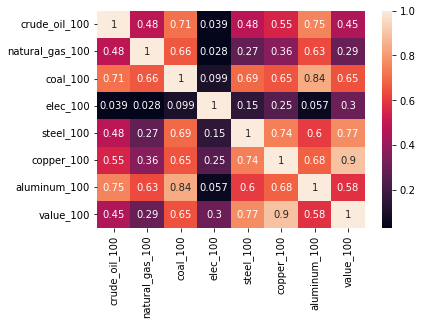

In [33]:
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [209]:
indicators = pd.read_csv('cleaned/indicators_100.csv')

In [20]:
sectors=hicp['sector'].unique()
countries=hicp['country'].unique()

In [21]:
data_train=pd.DataFrame(columns=['country', 'HICP'])
data_test=pd.DataFrame(columns=['country', 'HICP'])

In [24]:
index=0
for country in countries:
    data_train.loc[index,'country']=country
    data_test.loc[index,'country']=country
    for sector in sectors:
        X = indicators[indicators['country']==country]
        X=X.drop(['time', 'country'], axis=1)
        X=X.reset_index(drop=True)
        X=X.drop(X.index[[82, 83]])
        X=X.reset_index(drop=True)
        target = hicp[((hicp['country']==country) & (hicp['sector']==sector))]
        y=target['value_100']
        y=y.reset_index(drop=True)
        y=y.drop(y.index[[0, 1]])
        y=y.reset_index(drop=True)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        scaler = MinMaxScaler().fit(X_train)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)

        lm = LinearRegression()
        lm.fit(X_train_norm,y_train)

        predictions_train = lm.predict(X_train_norm)
        r_train=r2_score(y_train, predictions_train)
        predictions_test = lm.predict(X_test_norm)
        r_test=r2_score(y_test, predictions_test)
        data_train.loc[index, sector]=r_train
        data_test.loc[index, sector]=r_test
    index+=1

In [26]:
index=0
for country in countries:
    data_train.loc[index,'country']=country
    data_test.loc[index,'country']=country
    for sector in sectors:
        X = indicators[indicators['country']==country]
        X=X.drop(['time', 'country'], axis=1)
        X=X.reset_index(drop=True)
        X=X.drop(X.index[[81, 82]])
        X=X.reset_index(drop=True)
        target = hicp[((hicp['country']==country) & (hicp['sector']==sector))]
        y=target['value_100']
        y=y.reset_index(drop=True)
        y=y.drop(y.index[[1, 2]])
        y=y.reset_index(drop=True)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        scaler = MinMaxScaler().fit(X_train)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)
        KNN = KNeighborsRegressor(n_neighbors=3)
        KNN.fit(X_train_norm, y_train)
        score = KNN.score(X_test_norm, y_test)
        data_test.loc[index, sector]=score
    index+=1

In [27]:
data_test

,country,HICP
0,EU,0.957431
1,Belgium,0.946418
2,Bulgaria,0.934827
3,Czechia,0.970765
4,Denmark,0.906661
5,Germany,0.94441
6,Estonia,0.93461
7,Ireland,0.586107
8,Greece,0.449579
9,Spain,0.816659


In [132]:
data_test.to_csv('hicp-100-LR-2M-test.csv')